In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from skimage import io
from scipy import ndimage
from scipy.stats import linregress
import cv2
from preprocessing import preprocessing_v2 as pp


In [10]:
DATA_PATH = r'D:\amityu\backoffice_data\\'
movie ='130721_CCA60_RAW'
MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
image_sequence = pp.get_merged_spike(MOVIE_PATH,pp.get_ex_data(MOVIE_PATH))

In [4]:
# Load the dataframe
df = pd.read_csv(DATA_PATH + 'blob.csv')

# Display the first few rows
print(df.head())

# Example of the dataframe structure:
#    frame     y      x   sigma
# 0      1  100.5  150.3   5.2
# 1      1  200.7  250.8   4.8
# 2      2  105.2  155.1   5.5
# ...


   Unnamed: 0      y      x      sigma  frame
0           0  350.0  227.0  10.528034      0
1           1  483.0  138.0  15.084945      0
2           2  393.0  252.0  15.084945      0
3           3   80.0  511.0  10.528034      0
4           4  180.0  104.0  19.641855      0


Total number of frames: 62
Total number of blobs detected: 180567


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

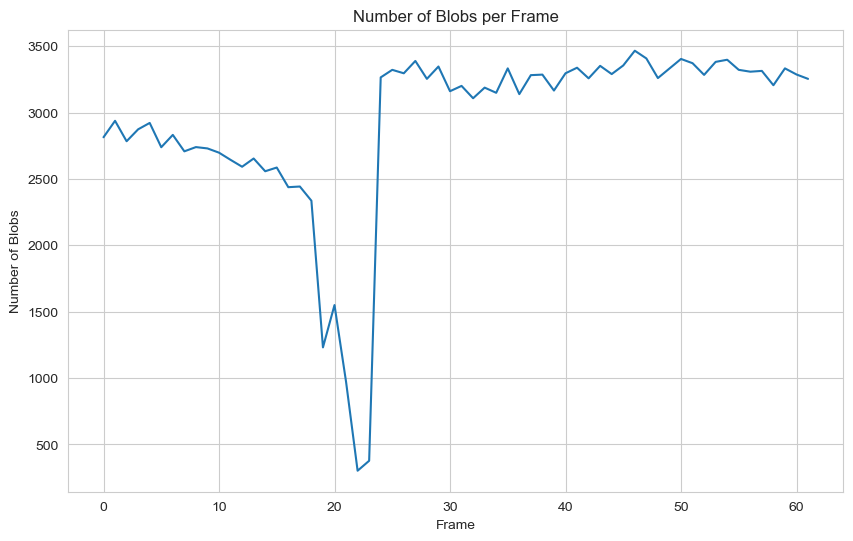

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


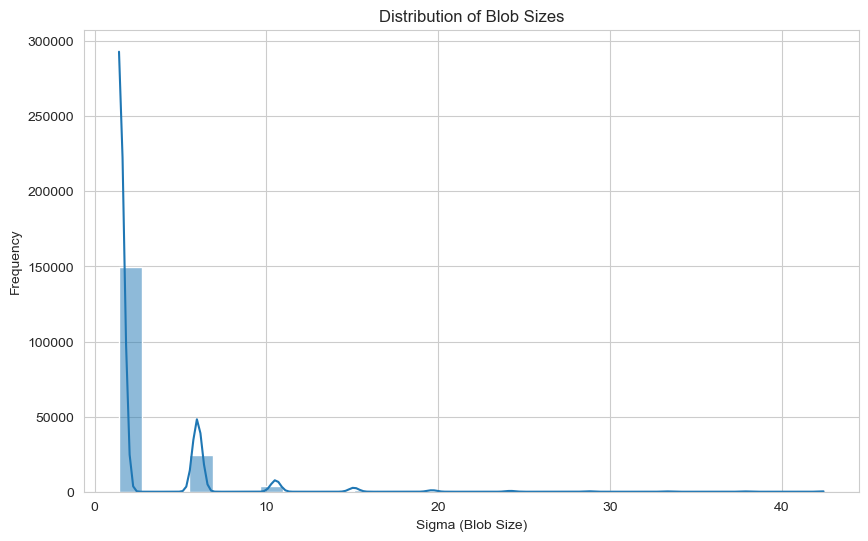

In [5]:
# Total number of frames
num_frames = df['frame'].nunique()
print(f"Total number of frames: {num_frames}")

# Total number of blobs
total_blobs = len(df)
print(f"Total number of blobs detected: {total_blobs}")

# Blobs per frame
blobs_per_frame = df['frame'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=blobs_per_frame.index, y=blobs_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Number of Blobs')
plt.title('Number of Blobs per Frame')
plt.show()

# Distribution of blob sizes (sigma)
plt.figure(figsize=(10, 6))
sns.histplot(df['sigma'], bins=30, kde=True)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Frequency')
plt.title('Distribution of Blob Sizes')
plt.show()


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

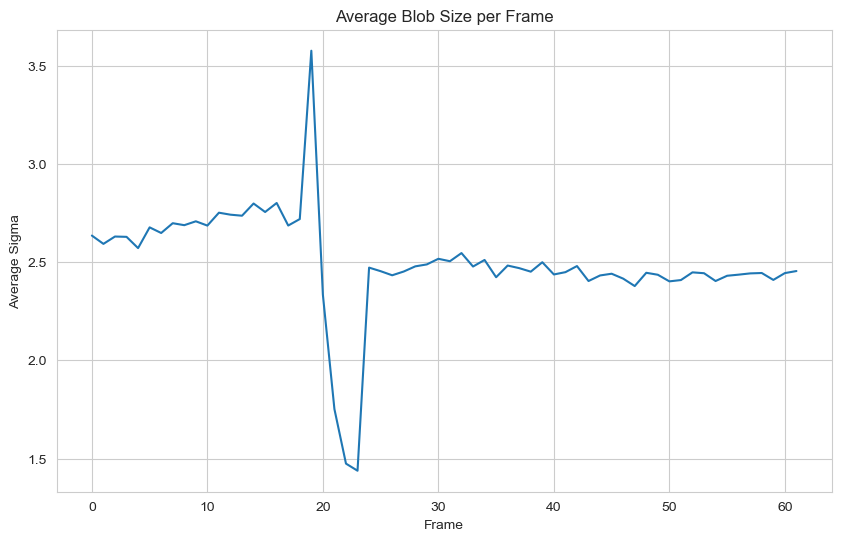

C:\Users\amityu\AppData\Local\Temp\ipykernel_27792\2906675669.py:14: RuntimeWarning: divide by zero encountered in log
  log_time = np.log(avg_sigma_per_frame.index.values)
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\numpy\lib\function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Coarsening exponent (slope): nan


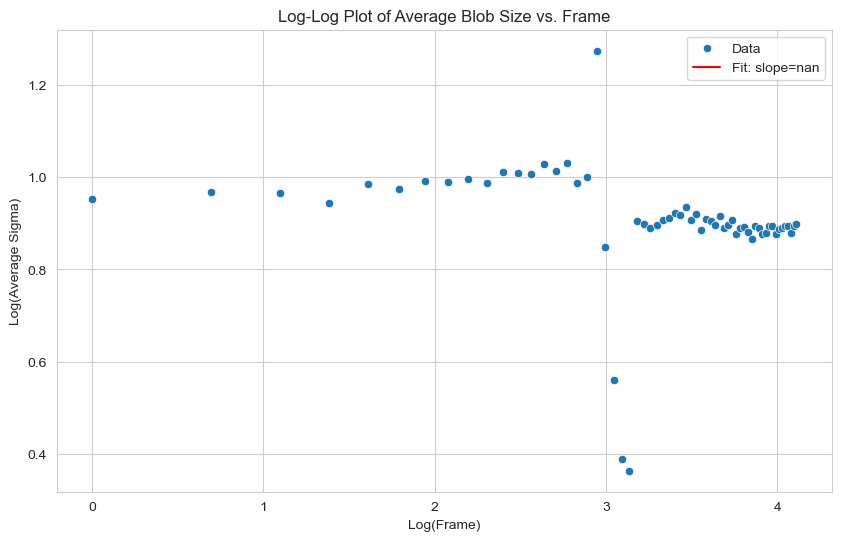

In [6]:
# Average blob size per frame
avg_sigma_per_frame = df.groupby('frame')['sigma'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_sigma_per_frame.index, y=avg_sigma_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Sigma')
plt.title('Average Blob Size per Frame')
plt.show()

# Fit a linear model to log-average sigma vs log-time to determine coarsening exponent
# Assuming frame number is proportional to time

log_time = np.log(avg_sigma_per_frame.index.values)
log_sigma = np.log(avg_sigma_per_frame.values)

slope, intercept, r_value, p_value, std_err = linregress(log_time, log_sigma)
print(f"Coarsening exponent (slope): {slope:.3f}")

# Plot with fitted line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=log_time, y=log_sigma, label='Data')
plt.plot(log_time, intercept + slope * log_time, 'r', label=f'Fit: slope={slope:.3f}')
plt.xlabel('Log(Frame)')
plt.ylabel('Log(Average Sigma)')
plt.title('Log-Log Plot of Average Blob Size vs. Frame')
plt.legend()
plt.show()


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

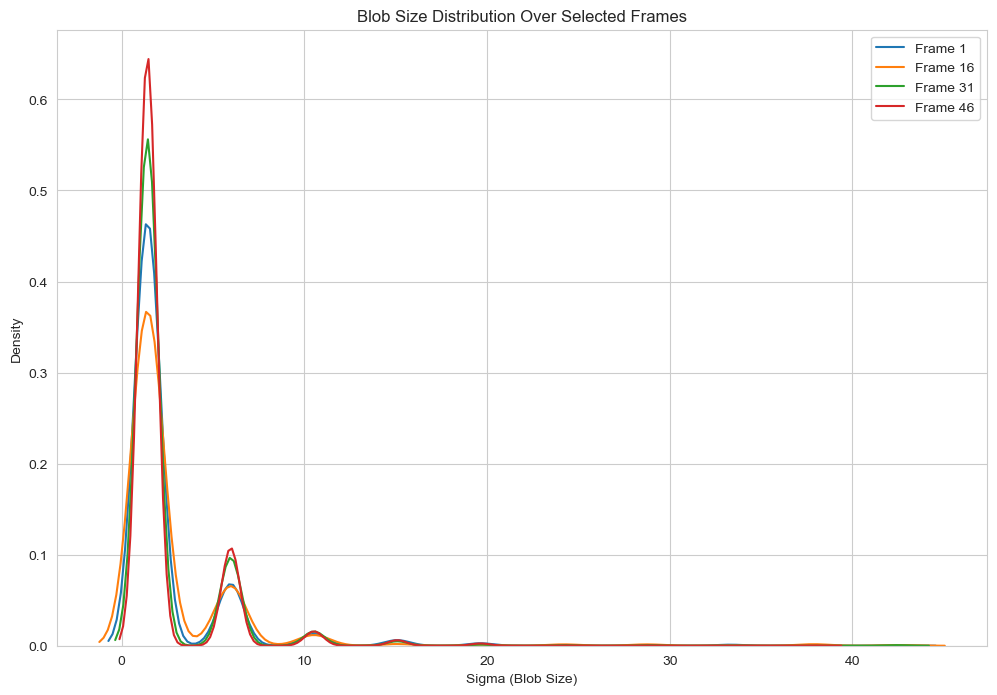

In [7]:
# Select frames to visualize distributions
selected_frames = np.linspace(1, num_frames, num=5, dtype=int)

plt.figure(figsize=(12, 8))
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma'], label=f'Frame {frame}')
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Density')
plt.title('Blob Size Distribution Over Selected Frames')
plt.legend()
plt.show()


In [11]:
# Function to extract average intensity of a blob
def extract_blob_intensity(image, y, x, sigma):
    # Define the radius based on sigma
    radius = int(3 * sigma)
    # Create a circular mask
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    dist_from_center = np.sqrt((Y - y)**2 + (X - x)**2)
    mask = dist_from_center <= radius
    # Calculate average intensity within the mask
    if np.sum(mask) == 0:
        return 0
    return image[mask].mean()

# Add a new column for intensity
df['intensity'] = 0.0

# Directory containing images

# Iterate through each frame and extract intensities
for frame in df['frame'].unique():
    # Construct image filename (modify according to your naming convention)
   
    # Load the image
    image = image_sequence[frame]
    # If images are not in grayscale, convert them
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Normalize image if necessary
    if image.max() > 1.0:
        image = image / 255.0
    # Select blobs in this frame
    frame_blobs = df[df['frame'] == frame].copy()
    # Extract intensities
    intensities = frame_blobs.apply(lambda row: extract_blob_intensity(image, row['y'], row['x'], row['sigma']), axis=1)
    # Assign to dataframe
    df.loc[frame_blobs.index, 'intensity'] = intensities

# Display updated dataframe
print(df.head())


   Unnamed: 0      y      x      sigma  frame  intensity
0           0  350.0  227.0  10.528034      0   0.135029
1           1  483.0  138.0  15.084945      0   0.139801
2           2  393.0  252.0  15.084945      0   0.141554
3           3   80.0  511.0  10.528034      0   0.139646
4           4  180.0  104.0  19.641855      0   0.139395


In [12]:
df.to_csv(DATA_PATH + 'blob_extended.csv')

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



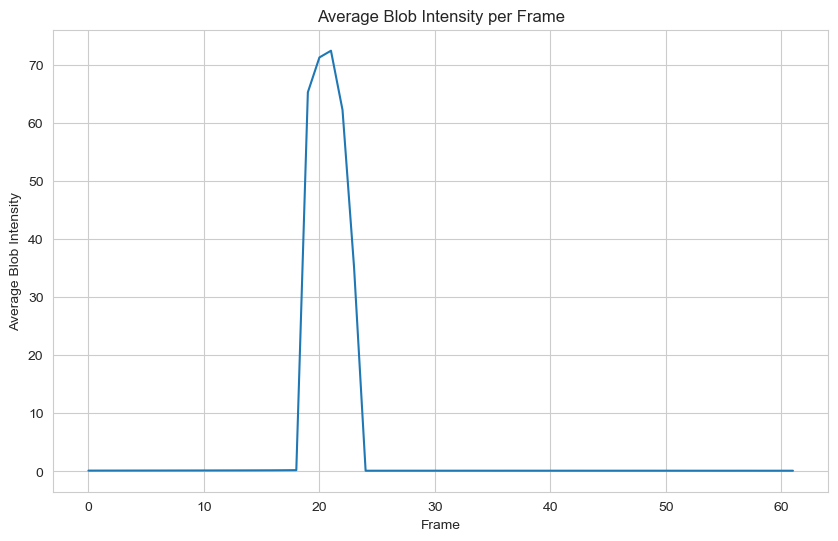

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



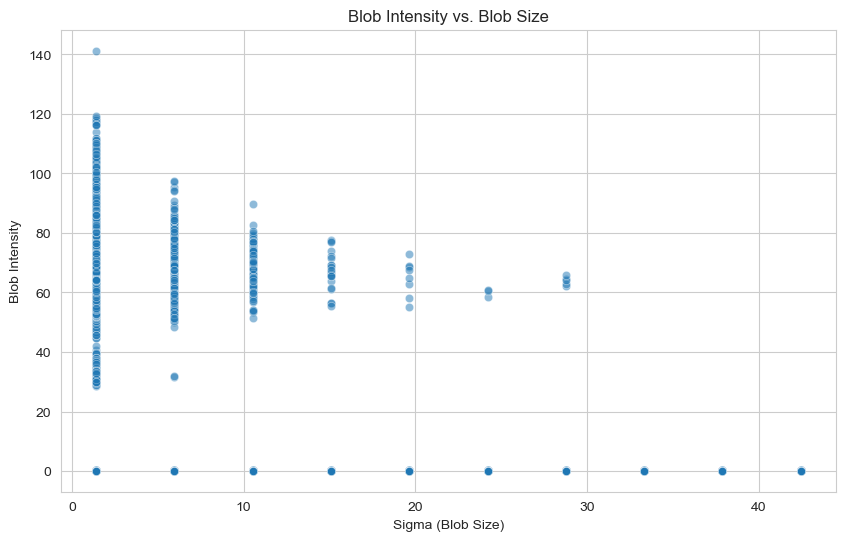

Correlation between blob size and intensity: -0.005


In [13]:
# Average intensity per frame
avg_intensity_per_frame = df.groupby('frame')['intensity'].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_intensity_per_frame.index, y=avg_intensity_per_frame.values)
plt.xlabel('Frame')
plt.ylabel('Average Blob Intensity')
plt.title('Average Blob Intensity per Frame')
plt.show()

# Correlation between blob size and intensity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sigma', y='intensity', data=df, alpha=0.5)
plt.xlabel('Sigma (Blob Size)')
plt.ylabel('Blob Intensity')
plt.title('Blob Intensity vs. Blob Size')
plt.show()

# Compute correlation coefficient
correlation = df['sigma'].corr(df['intensity'])
print(f"Correlation between blob size and intensity: {correlation:.3f}")


In [14]:
from scipy.spatial import cKDTree

# Initialize a dictionary to hold tracks
tracks = {}
current_track_id = 0

# Sort dataframe by frame
df_sorted = df.sort_values('frame')

# Parameters
max_distance = 20  # Maximum distance to consider the same blob across frames

# Iterate through frames
for frame in range(1, num_frames + 1):
    frame_blobs = df_sorted[df_sorted['frame'] == frame]
    if frame == 1:
        # Initialize tracks with first frame
        for idx, blob in frame_blobs.iterrows():
            tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
            df_sorted.at[idx, 'track_id'] = current_track_id
            current_track_id += 1
    else:
        # Get previous frame blobs with track IDs
        prev_frame = frame - 1
        prev_blobs = df_sorted[df_sorted['frame'] == prev_frame]
        prev_coords = prev_blobs[['y', 'x']].values
        prev_ids = prev_blobs['track_id'].values
        if len(prev_coords) == 0:
            # No previous blobs to track
            for idx, blob in frame_blobs.iterrows():
                tracks[current_track_id] = {'frames': [frame], 'y': [blob['y']], 'x': [blob['x']], 'sigma': [blob['sigma']]}
                df_sorted.at[idx, 'track_id'] = current_track_id
                current_track_id += 1
            continue
        # Build KD-tree for previous blobs
        tree = cKDTree(prev_coords)
        # Current frame blob coordinates
        current_coords = frame_blobs[['y', 'x']].values
        # Query nearest neighbors
        distances, indices = tree.query(current_coords, distance_upper_bound=max_distance)
        for i, (distance, index) in enumerate(zip(distances, indices)):
            if distance != np.inf:
                # Assign the track ID of the nearest previous blob
                track_id = prev_ids[index]
                tracks[track_id]['frames'].append(frame)
                tracks[track_id]['y'].append(current_coords[i][0])
                tracks[track_id]['x'].append(current_coords[i][1])
                tracks[track_id]['sigma'].append(frame_blobs.iloc[i]['sigma'])
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = track_id
            else:
                # Assign a new track ID
                tracks[current_track_id] = {'frames': [frame], 'y': [current_coords[i][0]], 'x': [current_coords[i][1]], 'sigma': [frame_blobs.iloc[i]['sigma']]}
                df_sorted.iloc[frame_blobs.index[i], df_sorted.columns.get_loc('track_id')] = current_track_id
                current_track_id += 1

# Display some tracks
for track_id, track in list(tracks.items())[:5]:
    print(f"Track {track_id}: Frames {track['frames']}, Positions {list(zip(track['y'], track['x']))}, Sigma {track['sigma']}")


Track 0: Frames [1, 2, 3, 4, 5, 6, 7], Positions [(74.0, 51.0), (77.0, 49.0), (440.0, 511.0), (298.0, 350.0), (26.0, 210.0), (496.0, 58.0), (230.0, 508.0)], Sigma [1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 1.4142135623730951, 5.971123930019735, 1.4142135623730951]
Track 1: Frames [1, 2, 2, 3, 3, 4, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 11, 12, 12, 13, 13, 13, 14, 15, 15, 16, 16, 17, 17], Positions [(136.0, 97.0), (137.0, 99.0), (134.0, 97.0), (319.0, 18.0), (55.0, 287.0), (501.0, 146.0), (207.0, 475.0), (207.0, 471.0), (80.0, 366.0), (85.0, 366.0), (87.0, 360.0), (35.0, 385.0), (354.0, 370.0), (40.0, 381.0), (217.0, 493.0), (88.0, 490.0), (81.0, 488.0), (419.0, 329.0), (64.0, 211.0), (67.0, 207.0), (121.0, 182.0), (72.0, 247.0), (146.0, 310.0), (145.0, 507.0), (140.0, 511.0), (232.0, 33.0), (258.0, 217.0), (261.0, 211.0), (470.0, 74.0), (63.0, 479.0), (62.0, 474.0), (2.0, 302.0), (6.0, 300.0), (192.0, 141.0), (386.0, 121.0)], Sigma [1.4

MovieWriter imagemagick unavailable; using Pillow instead.


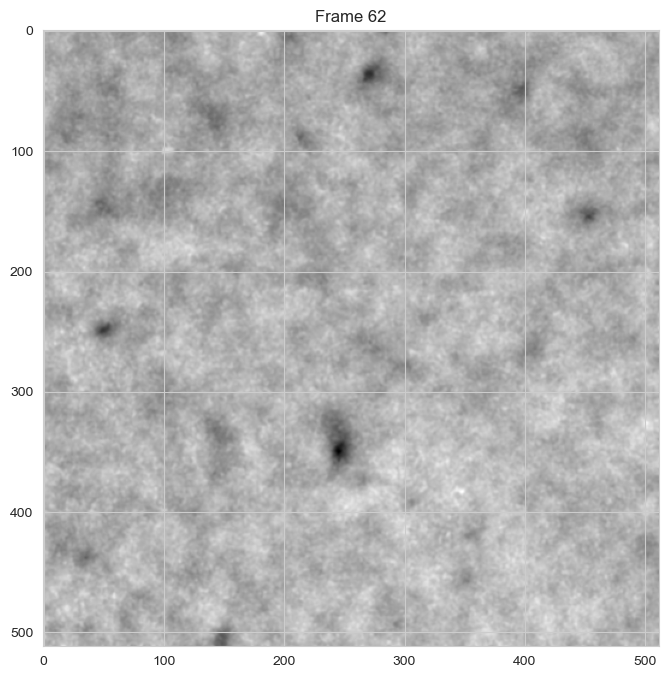

In [16]:
import matplotlib.patches as patches
from matplotlib import animation

# Load all images
images = image_sequence

# Normalize images
images = [img / img.max() for img in images]

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

def init():
    ax.imshow(images[0], cmap='gray')
    return []

def animate(frame_num):
    ax.clear()
    ax.imshow(images[frame_num], cmap='gray')
    # Plot blobs
    frame = frame_num + 1  # Assuming frame numbering starts at 1
    blobs = df[df['frame'] == frame]
    for _, blob in blobs.iterrows():
        circ = patches.Circle((blob['x'], blob['y']), radius=blob['sigma']*3, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(circ)
    ax.set_title(f'Frame {frame}')
    return []

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_frames, interval=200, blit=False)

# To display the animation in a Jupyter notebook
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# To save the animation as a GIF
anim.save('coarsening_animation.gif', writer='imagemagick')


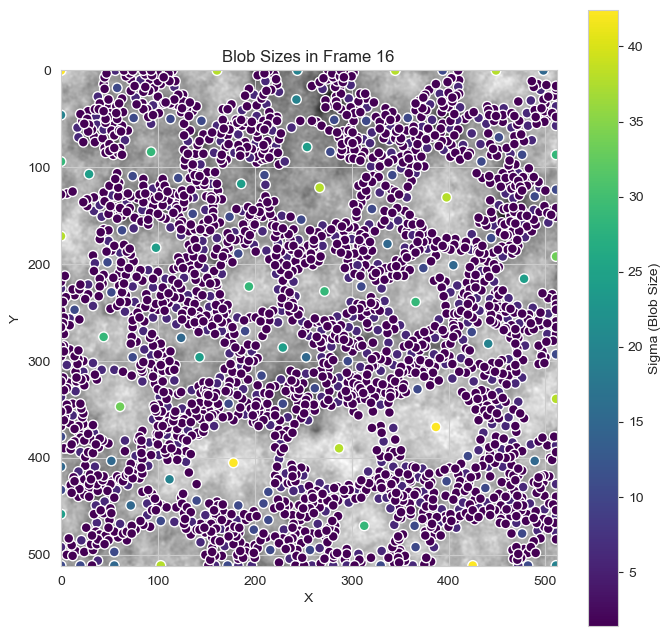

In [18]:
import matplotlib.colors as colors

# Select a frame to visualize
selected_frame = 16  # For example, the last frame

# Load the selected image
image = image_sequence[selected_frame]
if image.ndim == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = image / image.max()

# Get blobs for the selected frame
blobs = df[df['frame'] == selected_frame]

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
scatter = plt.scatter(blobs['x'], blobs['y'], c=blobs['sigma'], cmap='viridis', s=50, edgecolor='white')
plt.colorbar(scatter, label='Sigma (Blob Size)')
plt.title(f'Blob Sizes in Frame {selected_frame}')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [19]:
# Using the previously computed log-log slope
print(f"Coarsening exponent: {slope:.3f}")

# The coarsening rate can be inferred from the slope
# For example, if sigma ~ t^n, then slope ≈ n


Coarsening exponent: nan


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWa

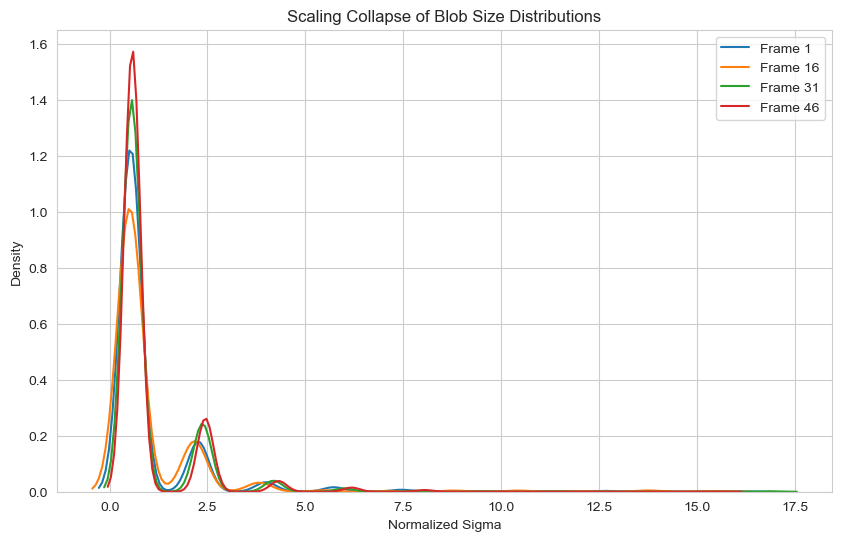

In [21]:
# Compute the characteristic size (e.g., average sigma)
char_size = avg_sigma_per_frame.values

# Normalize blob sizes
df['sigma_normalized'] = df.apply(lambda row: row['sigma'] / char_size[int(row['frame']) - 1], axis=1)

# Plot normalized size distributions
plt.figure(figsize=(10, 6))
for frame in selected_frames:
    subset = df[df['frame'] == frame]
    sns.kdeplot(subset['sigma_normalized'], label=f'Frame {frame}')
plt.xlabel('Normalized Sigma')
plt.ylabel('Density')
plt.title('Scaling Collapse of Blob Size Distributions')
plt.legend()
plt.show()
